# Manufacturing Data Science Assignment 4
## Question 1: Data Imbalance Problem
在 Kaggle 開放數據中包含了一個 信 用 卡 詐 欺 數 據 (Credit Card Fraud Detection ，
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)，信用卡公司能夠識別詐欺性信用卡交
易非常重要，這樣客戶就不會因未購買的商品而被收取費用。此資料集包含歐洲持卡人 2013
年 9 月透過信用卡進行的交易。該資料集顯示了兩天內發生的交易，其中 284,807 筆交易
中有 492 筆詐欺。資料集高度不平衡，正類（詐欺）佔所有交易的 0.172%。試著參考網路
資源學習並撰寫程式，使用此數據回答下列問題。

請閱讀此文章，”Best techniques and metrics for Imbalanced Dataset”
https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset/notebook.

### (a) 試在該數據分析流程中加入數據平衡的步驟，使用三種方法來進行數據平衡(e.g. 使用上抽樣、下抽樣或是代價敏感學習等)。
首先列出在這篇文章中已被驗證的幾個資料集特性：
* huge outliers
* higly skeved data
* a lot of outliers

接著進行 EDA 與 Data Preprocessing (部分程式碼來源：”Best techniques and metrics for Imbalanced Dataset”)：

In [1]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df.drop_duplicates(inplace=True)
df = df.drop('Time', axis=1)
# print(df.describe())
numeric_columns = (list(df.loc[:, 'V1':'Amount']))


X, y = df.drop('Class', axis= 1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

col_names = ['Amount']
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

接著使用 random oversampling、undersampling 以及 cost-sensitive learning 進行數據平衡，並且使用 Logistic Regression 模型，並且用 AUPRC 進行評估。

Random Oversampling: 0.726547633593626
Random Undersampling: 0.6201800108020427
Cost Sensitive Learning - Logistic: 0.7265260971538194


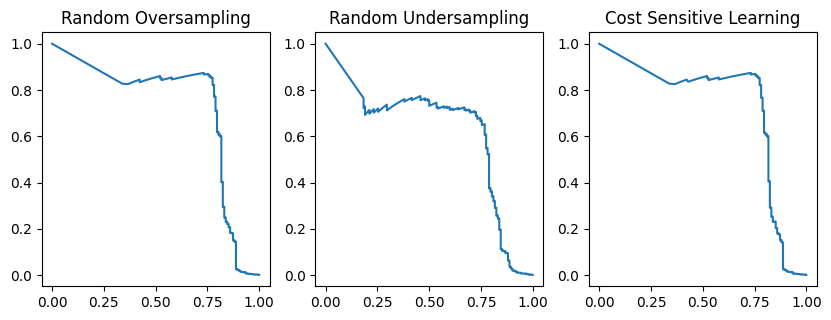

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Random Oversampling
# source: https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset/notebook#5.-Train-test-split---you-could-have-been-splitting-your-dataset-all-wrong
# define oversampling strategy
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(X_train, y_train)
model = LogisticRegression()
model.fit(X_over, y_over)
y_score = model.predict_proba(X_test)[:,1]
# source: https://sinyi-chou.github.io/python-sklearn-precision-recall/
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
# source ended
fig, ax = plt.subplots(1,3, figsize = (10, 3.3))
ax[0].plot(recall, precision)
ax[0].title.set_text('Random Oversampling')
print('Random Oversampling:', auc_precision_recall)

# Random Undersampling
ros = RandomUnderSampler()
X_und, y_und = ros.fit_resample(X_train, y_train)
model.fit(X_und, y_und)
y_score = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
ax[1].plot(recall, precision)
ax[1].title.set_text('Random Undersampling')
print('Random Undersampling:', auc_precision_recall)

# Cost sensitive learning

weighting = compute_class_weight(class_weight = 'balanced', classes=[0,1], y = y_train)
weighting = dict(zip([0,1], weighting))
model = LogisticRegression(class_weight=weighting)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)

print('Cost Sensitive Learning - Logistic:', auc_precision_recall)

ax[2].plot(recall, precision)
ax[2].title.set_text('Cost Sensitive Learning')
plt.show()


### (b) 承(a)，試比較三種方法？建議選用哪種方法最為合適？為什麼？

以 AUPRC 來看，上抽樣與代價敏感學習效果差不多，但下抽樣就表現的比較差，主要原因應該是懸殊的分類比例導致下抽樣使得樣本過少。

### (c) 對於數據多數群與少數群的比例應當調整至多少？為什麼？試透過調整生成比率 (i.e. 敏感度分析)來看模型分類結果。(提示：將敏感度分析以繪圖呈現兩條曲線，x 軸為不同生成比例、y 軸為偽陽性率(false positive rate)與偽陰性率(false negative rate))

同樣使用 Logistics Regression 模型，並且測試 minor / samples 從 Major 50%~90% 的生成比率繪製圖表。由圖可見 70 % 的時候可以獲得最低的偽陰性，而同時偽陽性又不至太高。

Genuine: 91 % of the dataset
Genuine: 83 % of the dataset
Genuine: 77 % of the dataset
Genuine: 71 % of the dataset
Genuine: 67 % of the dataset
Genuine: 63 % of the dataset
Genuine: 59 % of the dataset
Genuine: 56 % of the dataset
Genuine: 53 % of the dataset
Genuine: 50 % of the dataset


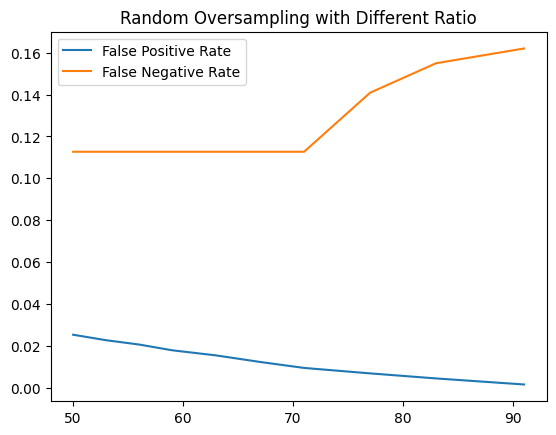

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kf = StratifiedKFold(n_splits=5, shuffle=False)
# print(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))



ratio = [round((0.1*m),1) for m in range(1, 11)]
percentage = []
fal_posi = []
fal_nega = []
for i, rat in enumerate(ratio):
    ros = RandomOverSampler(sampling_strategy = rat)
    X_over, y_over = ros.fit_resample(X_train, y_train)
    percentage.append(round(y_over.value_counts()[0]/len(y_over) * 100))
    print('Genuine:', percentage[i], '% of the dataset')
    model = LogisticRegression()
    model.fit(X_over, y_over)
    y_score = model.predict(X_test)
    cm = confusion_matrix(list(y_test), y_score)
    fal_nega.append(cm[1][0]/(cm[1][0] + cm[1][1]))
    fal_posi.append(cm[0][1]/(cm[0][1] + cm[0][0]))

plt.plot(percentage, fal_posi, label= 'False Positive Rate')
plt.plot(percentage, fal_nega, label= 'False Negative Rate')
plt.legend()
plt.title('Random Oversampling with Different Ratio')
plt.show()

### (d) 試說明特徵挑選步驟應於數據平衡前或後，這對預測結果有何影響？
* 特徵挑選應該在數據平衡前進行，因為特徵工程是專注在質，而數據平衡專注在量，而量的選擇應該要基於質，畢竟許多方法包含代價敏感分析都會需要在預測中逐步數據平衡，特徵工程應該要先做好才能達到最佳預測效果。
### (e) 就您觀點簡短敘述(不超過 200 字)，您覺得這文章”Best techniques and metrics for Imbalanced Dataset”還有什麼需要補充或改進的地方。
* 沒有特別就此份 Data 應該如何調整生成比率做測試，觀察如何造成影響。
* 此篇目的是要評斷各種數據平衡的方式，但 Training Model 卻只有使用隨機，沒有考慮隨機森林是否能夠對這份資料集做出很好的預測，因此各種數據平衡的優劣可能會被錯誤評斷。

## Question 2: Metaheuristic Algorithm
試求解工單式生產排程(job shop scheduling)問題，最小化最大完工時間(makespan)。資料來源
參考 Taillard's 排程案例
(http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/ordonnancement.html) ， 其
tai20_15 包含 20 個工件(job)與 15 個機台(machine)，每個工件有 15 個加工作業(operation)，
工件加工時間與工件加工機台順序如下表所示。
### (a) 試以基因演算法求解並說明其設計細節，包含染色體編碼、交配、突變、選擇、與相關參數(e.g. 母體大小、交配率、突變率等)；
* 染色體編碼：為排序編碼，每一條染色體包含 N * M 個基因，為加工序列的機器編號。
* 交配方式：根據交配率，採用隨機兩點擷取一段基因互換的方式。
* 突變：使用突變率隨機交換順序，即變動加工順序。 
* 選擇：採用輪盤法 (Roulette wheel) 的選擇機制，即根據適應值作為被隨機選擇到的機率。
* 相關參數預設值：母體大小 30、交配率 0.8、突變率 0.2、迭代次數 2000。
### (b) 若交配突變產生不可行的染色體，試建議染色體修復方法(repair)。
理論上每個工件在染色體出現的次數為 10 次，因此若是染色體內的工件出現次數會小於 10 或大於 10 即為不可行的排程解，因此需要將這些少於 10 的工件取代多於 10 的工件。
### (c) 撰寫相關程式求解，並呈現出最佳解與求解時間；

In [106]:

'''==========Solving job shop scheduling problem by gentic algorithm in python======='''
# importing required modules
import pandas as pd
import numpy as np
import time
import copy
''' ================= initialization setting ======================'''


pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time")
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence")

dfshape=pt_tmp.shape
num_mc=dfshape[1] # number of machines
num_job=dfshape[0] # number of jobs
num_gene=num_mc*num_job # number of genes in a chromosome

pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]

# raw_input is used in python 2
population_size=30 # default value is 30
crossover_rate=0.8 # default value is 0.8
mutation_rate=0.2 # default value is 0.2
mutation_selection_rate=0.2
num_mutation_jobs=round(num_gene*mutation_selection_rate)
num_iteration=2000 # default value is 2000
start_time = time.time()

'''----- generate initial population -----'''
Tbest=999999999999999
best_list,best_obj=[],[]
population_list=[]
TbestList = []
Tbest_now_list = []
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(num_gene)) # generate a random permutation of 0 to num_job*num_mc-1
    population_list.append(nxm_random_num) # add to the population_list
    for j in range(num_gene):
        population_list[i][j]=population_list[i][j]%num_job # convert to job number format, every job appears m times

        '''-------- two point crossover --------'''
for iter in range(num_iteration):
    parent_list=copy.deepcopy(population_list) # preserve the original parent chromosomes
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
        
    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if crossover_rate>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(num_gene, 2, replace=False))
            cutpoint.sort()
        
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]

    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break

    '''--------mutation--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg=list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position


    '''--------fitness value(calculate makespan)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}
        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1

        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]

    '''----------selection(roulette wheel approach)----------'''
    pk,qk=[],[]

    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)

    selection_rand=[np.random.rand() for i in range(population_size)]

    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
            
    '''----------comparison----------'''
    Tbest_now = 999999999999999
    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    Tbest_now_list.append(Tbest_now)
    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)
    TbestList.append(Tbest)
    '''----------result----------'''
print("optimal sequence",sequence_best)
print("optimal value:%f"%Tbest)
print('the elapsed time:%s'% (time.time() - start_time))

optimal sequence [1, 6, 5, 2, 10, 5, 15, 12, 2, 4, 5, 5, 4, 6, 0, 14, 10, 12, 14, 7, 2, 16, 6, 6, 12, 2, 15, 9, 17, 11, 9, 14, 5, 11, 17, 2, 3, 17, 12, 8, 10, 14, 3, 9, 0, 17, 6, 3, 1, 17, 14, 5, 18, 15, 9, 9, 10, 11, 11, 13, 1, 4, 10, 8, 1, 4, 15, 12, 16, 8, 16, 5, 18, 15, 16, 3, 3, 6, 1, 12, 12, 8, 9, 2, 14, 18, 17, 13, 17, 18, 14, 4, 0, 7, 1, 17, 3, 6, 9, 1, 1, 13, 4, 2, 7, 13, 13, 4, 1, 14, 5, 17, 9, 10, 12, 6, 0, 0, 0, 12, 16, 18, 11, 16, 10, 13, 5, 4, 13, 12, 13, 11, 7, 7, 15, 7, 14, 9, 10, 1, 18, 17, 0, 15, 5, 16, 11, 1, 16, 7, 10, 6, 2, 14, 3, 8, 17, 0, 13, 7, 13, 4, 14, 0, 5, 15, 18, 16, 2, 13, 10, 1, 1, 15, 4, 12, 5, 15, 8, 3, 9, 8, 17, 7, 4, 2, 18, 12, 7, 8, 15, 18, 16, 8, 5, 0, 9, 9, 2, 1, 18, 6, 15, 11, 17, 8, 6, 16, 11, 11, 16, 0, 18, 10, 8, 3, 18, 10, 16, 7, 14, 10, 7, 2, 12, 11, 8, 4, 13, 0, 6, 0, 7, 5, 0, 3, 18, 10, 2, 4, 18, 9, 6, 17, 12, 2, 8, 7, 4, 15, 11, 6, 8, 1, 9, 3, 14, 8, 14, 6, 12, 2, 11, 3, 13, 15, 16, 3, 7, 4, 14, 3, 18, 16, 3, 13, 11, 5, 15, 9, 17, 0, 11, 

### (d) 試繪製演算法收斂圖(e.g. x 軸為迭代、y 軸為適應值)，包含歷史迭代中最佳適應值與目前迭代回合的最佳適應值兩條曲線。

(參考文獻 Taillard, E. (1993). “Benchmarks for basic scheduling problems,” European Journal of Operational Research, 64(2), 278-285.)

(Hint: https://github.com/PO-LAB/Operations-Research-Applications ，基因演算法於生產排程 1 或基因演算法於生產排程 2)

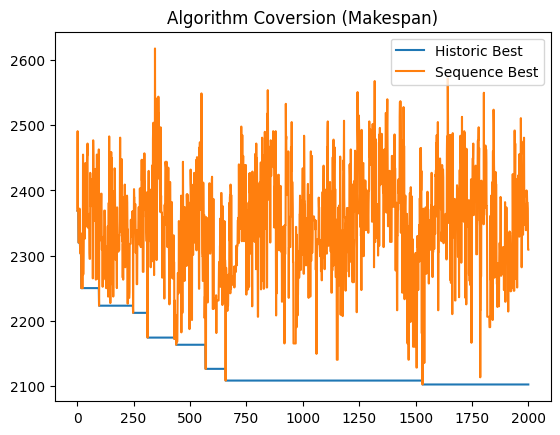

In [109]:
sequence = [x for x in range(1,2001)]
plt.plot(sequence, TbestList, label = 'Historic Best')
plt.plot(sequence, Tbest_now_list, label = 'Sequence Best')
plt.title('Algorithm Coversion (Makespan)')
plt.legend()
plt.show()